In [1]:
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt


In [2]:
X = torch.linspace(-4,4,1000).reshape(-1,1)
y = torch.cos(X) + torch.randn_like(X) * 0.2

train_n = len(X)
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

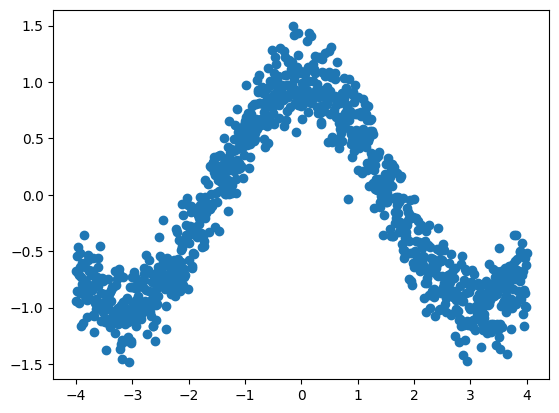

In [3]:
#plot the data
plt.scatter(train_x.cpu().numpy(), train_y.cpu().numpy(), label='Train')

In [4]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [5]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

number_inducing_points = 5
inducing_points = torch.linspace(-2,2,number_inducing_points).reshape(-1,1)
model = GPModel(inducing_points=inducing_points)


if torch.cuda.is_available():
    model = model.cuda()

In [6]:
num_epochs = 1000

model.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()}
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0))


epochs_iter = tqdm.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        y_batch=y_batch.reshape(-1,)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()

Epoch: 100%|██████████| 1000/1000 [00:13<00:00, 75.30it/s]


In [7]:
X = torch.linspace(-4,4,1000).reshape(-1,1)
X=X.cuda()
model.eval()

with torch.no_grad() :
    x_inducing=model.variational_strategy.inducing_points
    y_inducing=model.variational_strategy.pseudo_points[1]
    var_inducing=model.variational_strategy.pseudo_points[0]
    kernel=model.covar_module
    k_star=kernel(X,x_inducing)
    K=(kernel(x_inducing,x_inducing)).evaluate() + var_inducing
    K_inv=torch.linalg.inv(K)
    alpha=K_inv @ y_inducing
    mu_exact= kernel(X,x_inducing) @ alpha
    k_start_start=kernel(X,X)
    R= torch.ones_like(var_inducing).cuda()- var_inducing
    noise= torch.eye(k_start_start.shape[0]).cuda()*model.likelihood.noise
    sigma_exact=k_start_start -kernel(X,x_inducing) @ K_inv @ (kernel(x_inducing,X))
    sigma_exact_noise=sigma_exact+noise
    sigma_exact= sigma_exact.evaluate()
    sigma_exact_noise= sigma_exact_noise.evaluate()
    std_exact=torch.sqrt(torch.diag(sigma_exact)).reshape(-1,1)
    std_exact_noise=torch.sqrt(torch.diag(sigma_exact_noise)).reshape(-1,1)

In [8]:
prediction=model.likelihood(model(X))
mu_svgp=prediction.mean.reshape(-1,1)
sigma_svgp=prediction.variance
std_svgp=torch.sqrt(sigma_svgp).reshape(-1,1)

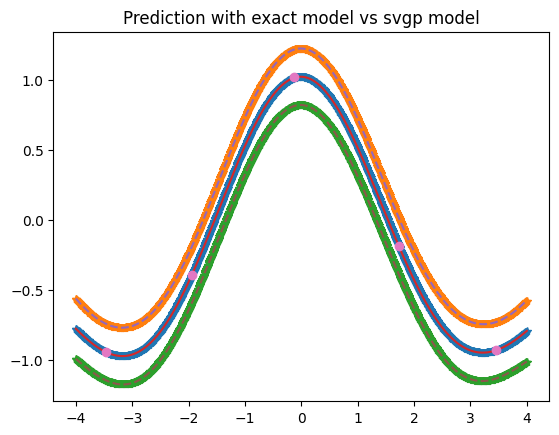

In [9]:
with torch.no_grad():
    plt.plot(X.cpu(),mu_exact.cpu(), '-*')
    plt.plot(X.cpu(), mu_exact.cpu()+std_exact_noise.cpu(), '-*')
    plt.plot(X.cpu(), mu_exact.cpu()-std_exact_noise.cpu(), '-*')

    plt.plot(X.cpu(),mu_svgp.cpu())
    plt.plot(X.cpu(), mu_svgp.cpu()+std_svgp.cpu(), '--')
    plt.plot(X.cpu(), mu_svgp.cpu()-std_svgp.cpu(), '--')
    plt.plot(x_inducing.cpu(), y_inducing.cpu(), 'o')
    plt.title('Prediction with exact model vs svgp model')

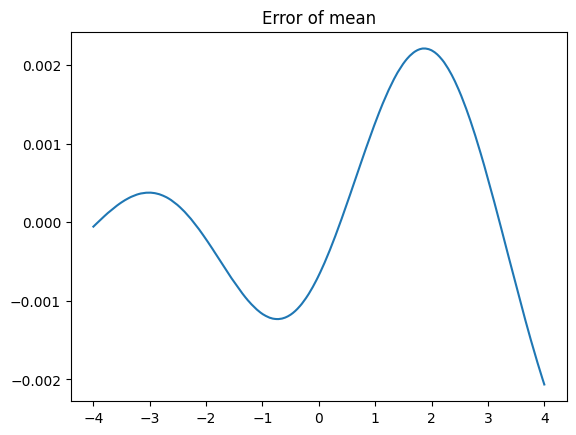

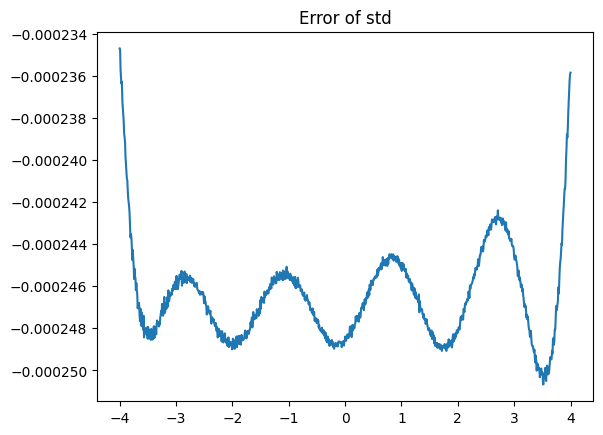

In [10]:
with torch.no_grad():
    #  compute and plot the error of meand and std
    error_mean=mu_exact-mu_svgp
    error_std=std_exact_noise-std_svgp
    plt.figure()
    plt.plot(X.cpu(),error_mean.cpu())
    plt.title('Error of mean')
    plt.figure()
    plt.plot(X.cpu(),error_std.cpu())
    plt.title('Error of std')

    plt.show()

In [11]:
K_fz= model.covar_module(X, x_inducing).evaluate().cpu().detach()

In [12]:
model.variational_strategy._variational_distribution.variational_mean

Parameter containing:
tensor([-1.7353,  0.8634,  2.5738, -3.5574,  0.4051], device='cuda:0',
       requires_grad=True)

In [13]:
Z= model.variational_strategy.inducing_points

In [14]:
model.variational_strategy.variational_distribution.mean

Parameter containing:
tensor([-1.7353,  0.8634,  2.5738, -3.5574,  0.4051], device='cuda:0',
       requires_grad=True)

In [15]:
model.variational_strategy.variational_distribution.lazy_covariance_matrix.evaluate()

tensor([[ 0.0009, -0.0010,  0.0008, -0.0006,  0.0004],
        [-0.0010,  0.0026, -0.0025,  0.0019, -0.0015],
        [ 0.0008, -0.0025,  0.0039, -0.0036,  0.0030],
        [-0.0006,  0.0019, -0.0036,  0.0048, -0.0048],
        [ 0.0004, -0.0015,  0.0030, -0.0048,  0.0073]], device='cuda:0')